# Estimating distributions
How much loss will we incur by sampling `O(2^L)` times from the circuit and building an empirical distribution instead of using the true distribution from the Qiskit backend?

A natural way to answer this is to do the estimate, then find the KL divergence as a function of the `nrun` parameter, which controls the amount of random noise we are willing to tolerate. we can then plot this. The purpose of this notebook is to guide what the `nrun` parameter should be. It should be large enough to kill off most noise, but small enough to be efficiently implementable.

In [6]:
from qiskit.quantum_info import Statevector
from __helpers import qubit_retraction
import numpy as np
from GHZ_generator import GHZ_state_circuit
import matplotlib.pyplot as plt
from __loss_funcs import KL
%matplotlib inline

In [7]:
NUM_QUBITS = 3
RUN_RANGE = (100, 1000, 25) # min, max, step size
STATE_TYPE = 'XY'

In [8]:
state = None
if STATE_TYPE == 'GHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from GHZ_generator import GHZ_state_circuit
    state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = GHZ_state_circuit(L=NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'XY':
    # Prepare: XY(L) (from: ED)
    from XY_generator import xy_ground_state
    state = Statevector(xy_ground_state(NUM_QUBITS).numpy())
elif STATE_TYPE == 'Cluster':
    # Prepare cluster(L) (from: Q-circuit)
    from cluster_generator import cluster_state_circuit
    state = Statevector.from_int(0, 2**(NUM_QUBITS**2))
    qc = cluster_state_circuit(NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
else:
    raise TypeError("Invalid state type specified.")

Running on the CPU
Ground state energy of XY(3): (3.4949498176574707+6.145571163074237e-09j)


In [9]:
def retrieve_dists(L, nrun, poly=None):
    """Returns the true distribution and the estimate"""
    units = 2**L if poly is None else L**poly
    estimate = np.zeros(2**L)
    for _ in range(nrun * units):
        estimate[qubit_retraction(state.measure()[0])] += 1
    estimate /= nrun * units
    return state.probabilities(), estimate

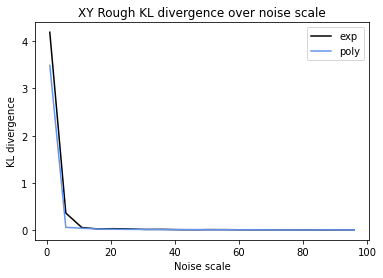

In [10]:
nruns = list(range(1, 100, 5))
exploss = np.ones_like(nruns, dtype=float)
polyloss = np.ones_like(nruns, dtype=float)
for i, nrun in enumerate(nruns):
    exploss[i] = np.mean([KL(*retrieve_dists(NUM_QUBITS, nrun)) for _ in range(10)])
    polyloss[i] = np.mean([KL(*retrieve_dists(NUM_QUBITS, nrun, poly=2)) for _ in range(10)])

plt.plot(nruns, exploss, label='exp', c='k')
plt.plot(nruns, polyloss, label='poly', c='cornflowerblue')
plt.legend()
plt.xlabel(r"Noise scale")
plt.ylabel("KL divergence")
plt.title(f"{STATE_TYPE} Rough KL divergence over noise scale")
plt.show()

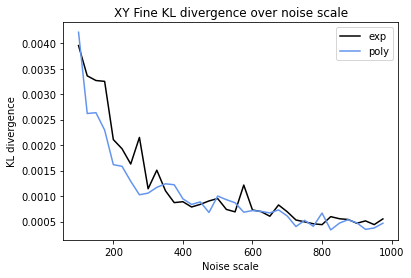

In [11]:
nruns = list(range(*RUN_RANGE))
exploss = np.ones_like(nruns, dtype=float)
polyloss = np.ones_like(nruns, dtype=float)
for i, nrun in enumerate(nruns):
    exploss[i] = np.mean([KL(*retrieve_dists(NUM_QUBITS, nrun)) for _ in range(10)])
    polyloss[i] = np.mean([KL(*retrieve_dists(NUM_QUBITS, nrun, poly=2)) for _ in range(10)])

plt.plot(nruns, exploss, label='exp', c='k')
plt.plot(nruns, polyloss, label='poly', c='cornflowerblue')
plt.legend()
plt.xlabel(r"Noise scale")
plt.ylabel("KL divergence")
plt.title(f"{STATE_TYPE} Fine KL divergence over noise scale")
plt.show()